#                                             UNICORN COMPANY

## Author : Prathmesh Mhatre

## Problem Statement 
                1.Which are the top ten countries with the most startups? Which are the top three?
                2.Which are the ten cities with the most startups? Which are the top three?
                3.How many Unicorns are there in each industry?
                4.Which are the most valuable unicorns? Which are the deacorns?
                5.How many companies have joined the club of unicorns each year? In which year do we have the most unicorns?
                6.What is the Global unicorn activity by industry

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

In [26]:
df=pd.read_csv('Unicorn_Companies.csv')

In [27]:
df.head(2)

,Company,Valuation_B$,Date Joined,Industry,City,Country,Continent,Year Founded,Funding,Select Investors
0,Bytedance,180,07-04-2017,Artificial intelligence,Beijing,China,Asia,2012,8.0,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,100,01-12-2012,Other,Hawthorne,United States,North America,2002,7.0,"Founders Fund, Draper Fisher Jurvetson, Rothen..."


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1074 non-null   object 
 1   Valuation_B$      1074 non-null   int64  
 2   Date Joined       1074 non-null   object 
 3   Industry          1074 non-null   object 
 4   City              1058 non-null   object 
 5   Country           1074 non-null   object 
 6   Continent         1074 non-null   object 
 7   Year Founded      1074 non-null   int64  
 8   Funding           1074 non-null   float64
 9   Select Investors  1073 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 84.0+ KB


In [29]:
df.rename(columns={"Date Joined":"Date_Joined", "Select Investors":"Select_Investors","Year Founded" :"Year_Founded"}, inplace=True)

In [30]:
df.isna().sum() # showing the number of NaN values

Company              0
Valuation_B$         0
Date_Joined          0
Industry             0
City                16
Country              0
Continent            0
Year_Founded         0
Funding              0
Select_Investors     1
dtype: int64

In [31]:
empt_city_mask = df.loc[:,"City"].isna() #creating a mask to filter our data
nan_city = df.loc[empt_city_mask, ["Company","Country", "City"]] # excrating the exact NaN values
print(nan_city["Country"].value_counts())
nan_city.head(3)

Singapore    12
Hong Kong     3
Bahamas       1
Name: Country, dtype: int64


,Company,Country,City
12,FTX,Bahamas,NaN
170,HyalRoute,Singapore,NaN
242,Moglix,Singapore,NaN


In [32]:
# 2. using fillna() and replacing our values

df.loc[:, "City"].fillna(df.loc[:, "Country"], inplace=True)

# now we have to change the three city seperately:
df["City"][10] = "Nassau"
df["City"][314] = "Singapore"
df["City"][928] = "Sheung Wan"

df.loc[:,"City"].isna().sum()

0

We do the same for the last NaN value In Investors columns

In [33]:
df["Select_Investors"].isna().sum()
empt_invest_mask = df.loc[:,"Select_Investors"].isna()
nan_invest = df.loc[empt_invest_mask, :]
print(nan_invest["Company"].value_counts())
nan_invest

LinkSure Network    1
Name: Company, dtype: int64


,Company,Valuation_B$,Date_Joined,Industry,City,Country,Continent,Year_Founded,Funding,Select_Investors
629,LinkSure Network,1,01-01-2015,Mobile & telecommunications,Shanghai,China,Asia,2013,0.052,NaN


In [34]:
df["Select_Investors"][629] = "Haitong Kaiyuan Investment, Northern Light Venture Capital, and Undisclosed Investors" 

In [35]:
df.loc[:, "Date_Joined"] = pd.to_datetime(df.loc[:, "Date_Joined"], format="%d-%m-%Y", )
# df.info()

In [36]:
cols = ["Company", "Country", "City", "Industry"]

for col in cols: # a foor loop to check all the columns
    check = df[col].unique()
    for name in check:  
        matches = fuzzywuzzy.process.extract(name, check, limit=2, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        if matches[1][1] > 90:
            print(matches)

[('Gusto', 100), ('Gousto', 91)]
[('Upgrade', 100), ('UpGrad', 92)]
[('SSENSE', 100), ('Sisense', 92)]
[('Gousto', 100), ('Gusto', 91)]
[('fabric', 100), ('Fabric', 100)]
[('UpGrad', 100), ('Upgrade', 92)]
[('Sisense', 100), ('SSENSE', 92)]
[('fabric', 100), ('Fabric', 100)]
[('Hangzhou', 100), ('Changzhou', 94)]
[('Changzhou', 100), ('Hangzhou', 94)]
[('Artificial intelligence', 100), ('Artificial Intelligence', 100)]
[('Artificial intelligence', 100), ('Artificial Intelligence', 100)]


It we have only in the Industry column dupplicates value and in four categories: Artificial intelligence', Auto & transportation, Cybersecurity and Consumer & retail

In [37]:
df["Industry"].value_counts()

Fintech                                224
Internet software & services           205
E-commerce & direct-to-consumer        111
Health                                  74
Artificial intelligence                 73
Other                                   58
Supply chain, logistics, & delivery     57
Cybersecurity                           50
Data management & analytics             41
Mobile & telecommunications             38
Hardware                                34
Auto & transportation                   31
Edtech                                  28
Consumer & retail                       25
Travel                                  14
Artificial Intelligence                 11
Name: Industry, dtype: int64

In [38]:

def replace_matches_in_column(df, column, string_to_match, min_ratio = 80):
    """
     function to replace rows in the provided column of the provided dataframe
     that match the provided string above the provided ratio with the provided string
    """
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [39]:
# 3.witn str.lower , str.strip and fuzzywuzzy and
industries = df["Industry"].unique()
for industry in industries:
    replace_matches_in_column(df=df, column="Industry", string_to_match=industry)

In [40]:
df["Industry"].value_counts()

Fintech                                224
Internet software & services           205
E-commerce & direct-to-consumer        111
Artificial Intelligence                 84
Health                                  74
Other                                   58
Supply chain, logistics, & delivery     57
Cybersecurity                           50
Data management & analytics             41
Mobile & telecommunications             38
Hardware                                34
Auto & transportation                   31
Edtech                                  28
Consumer & retail                       25
Travel                                  14
Name: Industry, dtype: int64

In [41]:
#getting the joined year, month and day 
df['year'] = df['Date_Joined'].apply(lambda datetime: datetime.year)
df["month"] = df['Date_Joined'].apply(lambda datetime: datetime.month)
df["day"] = df['Date_Joined'].apply(lambda datetime: datetime.day)
df.head(2)

,Company,Valuation_B$,Date_Joined,Industry,City,Country,Continent,Year_Founded,Funding,Select_Investors,year,month,day
0,Bytedance,180,2017-04-07,Artificial Intelligence,Beijing,China,Asia,2012,8.0,"Sequoia Capital China, SIG Asia Investments, S...",2017,4,7
1,SpaceX,100,2012-12-01,Other,Hawthorne,United States,North America,2002,7.0,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2012,12,1


#### Now our DataFrame is modified and cleaned up! So it is ready to explore!!!

#### 1.Which are the top ten countries with the most startups? Which are the top three?

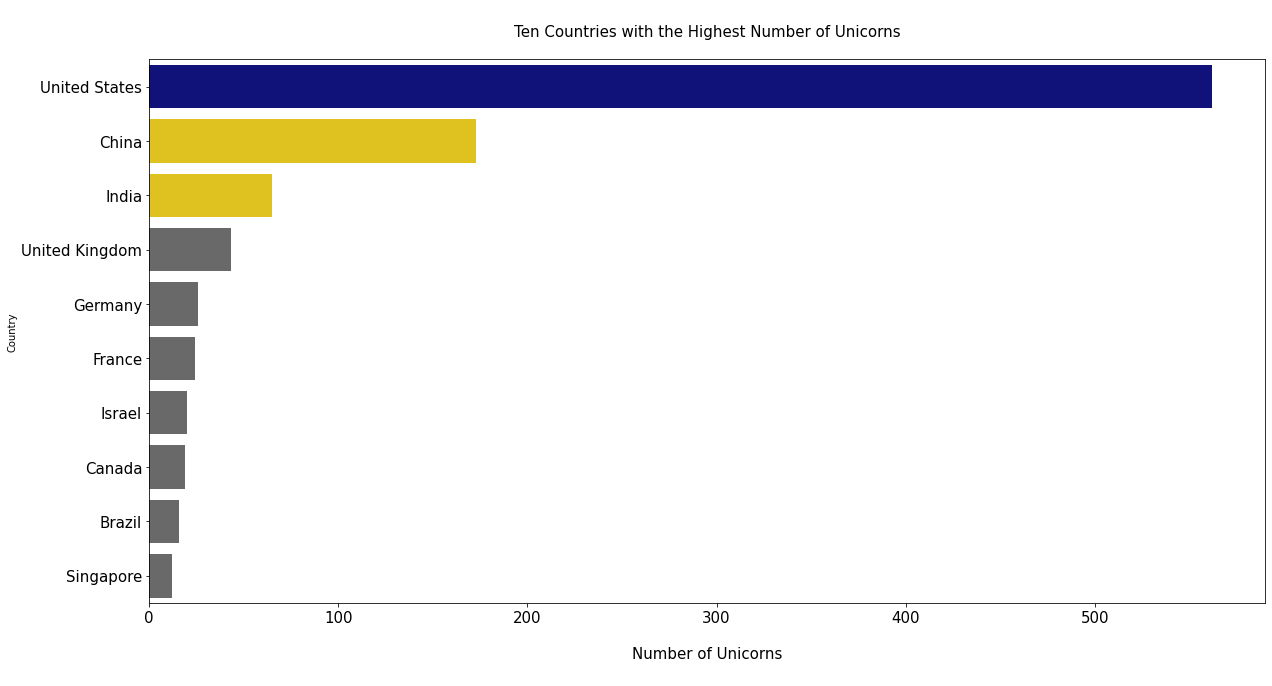

In [42]:
fig, ax= plt.subplots(figsize=(20,10))

country_color = ["darkblue","gold", "gold", "dimgray", "dimgray", "dimgray", "dimgray", "dimgray", "dimgray",
             "dimgray","dimgray","dimgray"] # creating colors

sns.countplot(y="Country", data=df, order=df["Country"].value_counts().index[:10],  palette=country_color, ax=ax)
ax.set_title("\nTen Countries with the Highest Number of Unicorns\n", fontsize=15, fontweight="normal");
ax.set_xlabel("\nNumber of Unicorns\n", fontsize=15);
ax.tick_params(axis="both", labelsize=15)
# percentage of unicorns per country
top_10_countries = pd.crosstab(index=df["Country"], columns="count", normalize=True).sort_values(by="count", ascending=False)


1.74% of all unicorns belong to the United States, China, and India.
2.The United States stands in first place with 54% of all unicorns.

#### 2.Which are the ten cities with the most startups? Which are the top three?

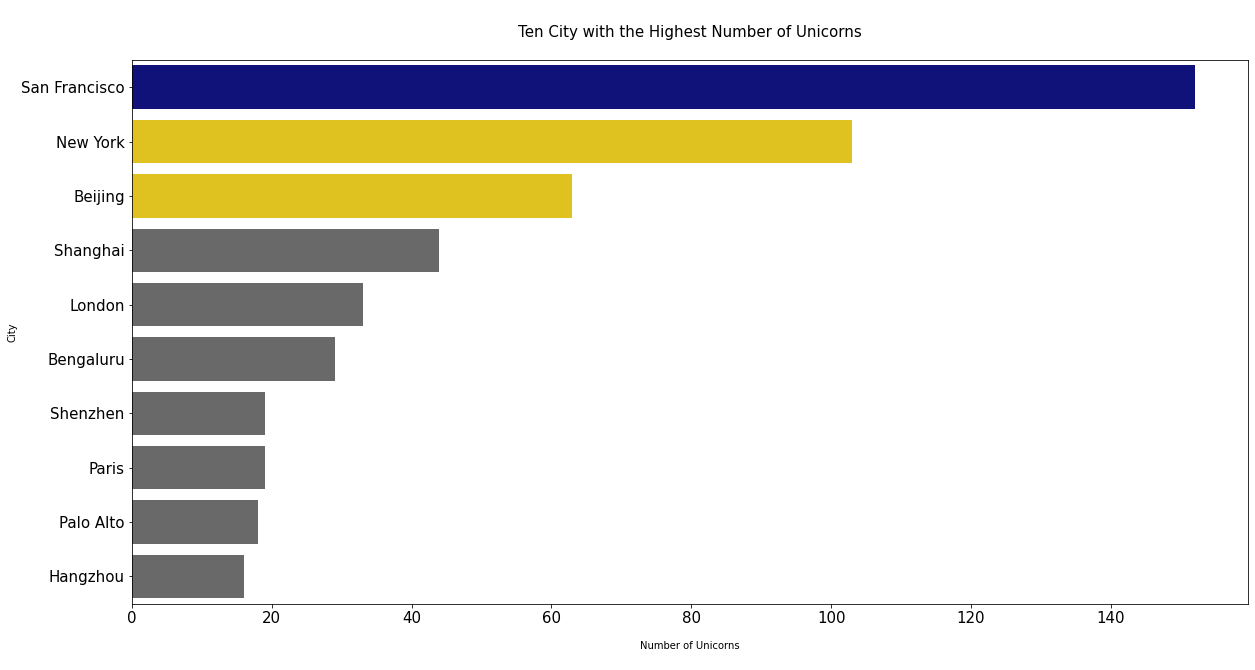

In [43]:
fig, ax= plt.subplots(figsize=(20,10))
city_color = ["darkblue","gold", "gold", "dimgray", "dimgray", "dimgray", "dimgray", "dimgray", "dimgray",
             "dimgray","dimgray","dimgray"] # creating colors

sns.countplot(y="City", data=df, order=df["City"].value_counts().index[:10],  palette=city_color, ax=ax)
ax.set_title("\nTen City with the Highest Number of Unicorns\n", fontsize=15);
ax.set_xlabel("\nNumber of Unicorns\n", fontsize=10);
ax.tick_params(axis="both", labelsize=15)

# percentage of unicorns per city
top_10_city = pd.crosstab(index=df["City"], columns="count", normalize=True).sort_values(by="count", ascending=False)
top_10_city=round(top_10_city, ndigits=2) *100

1.28% of all unicorns belong to the San Francisco,New York, and Beijing. 
2.The San Francisco stands in first place with 14% of all unicorns

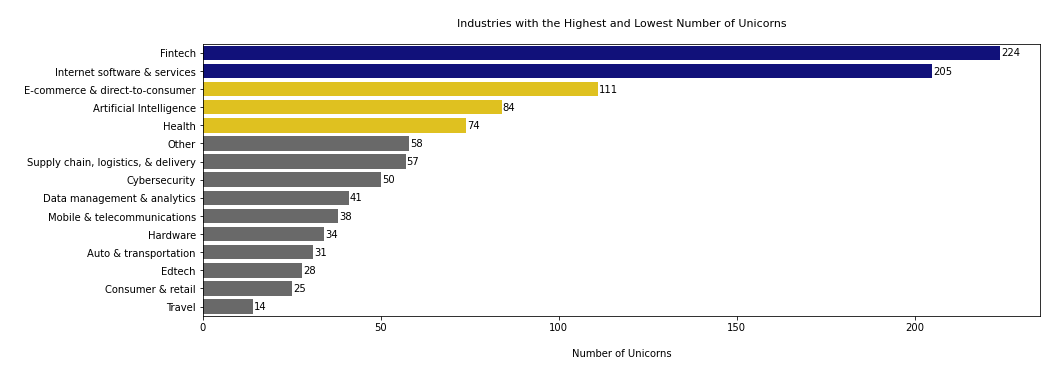

In [44]:
fig, ax= plt.subplots(figsize=(15,5))
industry_color = ["darkblue","darkblue", "gold", "gold", "gold", "dimgray", "dimgray",
             "dimgray","dimgray","dimgray", "dimgray", "dimgray", "dimgray", "dimgray",  "dimgray"]

sns.countplot(y="Industry", data=df, order=df["Industry"].value_counts().index,  palette=industry_color, ax=ax)
ax.bar_label(ax.containers[0], label_type="edge", padding=1); # add value lables
ax.set_title("\nIndustries with the Highest and Lowest Number of Unicorns\n", fontsize=11, fontweight="normal");
ax.set_ylabel(" ", fontsize=13, fontweight="normal");
ax.set_xlabel("\nNumber of Unicorns\n", fontsize=10);
ax.tick_params(axis="both", labelsize=10)
# percentage of unicorns per indusrty
top_10_industry = pd.crosstab(index=df["Industry"], columns="count", normalize=True).sort_values(by="count", ascending=False)
top_10_industry=round(top_10_industry, ndigits=2) *100

1.The first five industry account for 64% of all unicorns.
2.Fintech is the leading industry with 21% of all unicorns.

#### 4.Which are the most valuable unicorns? Which are the deacorns?

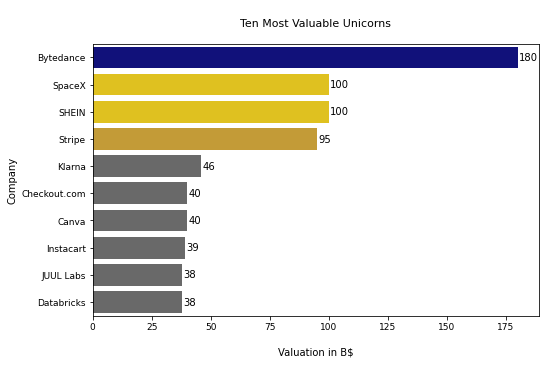

In [45]:
# using croostable to extracting the data
top_10_company = pd.crosstab(index=df.loc[:,"Company"], columns="Valuation_B$", values=df.loc[:,"Valuation_B$"], aggfunc="sum").sort_values(
    by="Valuation_B$",ascending=False)
top_10_company.reset_index(inplace=True)
top_10_company.rename(columns={"index": "Company"}, inplace=True)
top_10_company= top_10_company[:10]
fig, ax= plt.subplots(figsize=(8,5))
unicorn_color = ["darkblue","gold", "gold", "goldenrod", "dimgray", "dimgray", "dimgray", "dimgray", "dimgray",
             "dimgray","dimgray","dimgray"] # creating colors
sns.barplot(data=top_10_company, x="Valuation_B$", y="Company", orient="h", ax=ax, palette= unicorn_color)
ax.bar_label(ax.containers[0], label_type="edge", padding=1); # add value lables
ax.set_title("\nTen Most Valuable Unicorns\n", fontsize=11, fontweight="normal");
ax.set_xlabel("\nValuation in B$\n", fontsize=10);
ax.tick_params(axis="both", labelsize=9)

1.The top four unicorns are worth more than $50 billion.
2.The most valuable companies are in China and the next two are in the United States.
3.They operate in the following areas: Artificial Intelligence, Space & Communications,E-Commerce & Direct-to-Consumer, and Fintech.
4.ByteDance is the Hecocorn, SpaceX and SHEIN are the Deacorns."

#### 5.How many companies have joined the club of unicorns each year? In which year do we have the most unicorns?

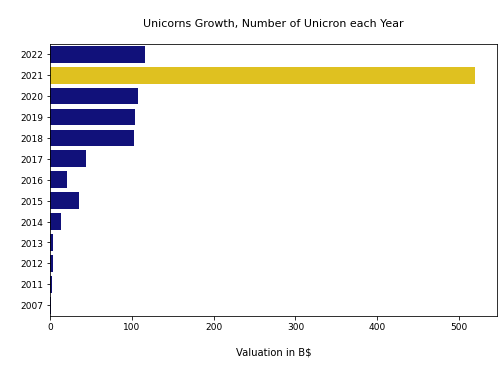

In [46]:
uni_year = pd.crosstab(index=df.loc[:,"year"], columns="Company", values=df.loc[:,"Company"], aggfunc="count").sort_values(
    by="Company",ascending=False)
uni_year.reset_index(inplace=True)
uni_year.rename(columns={"index": "Company"}, inplace=True)
uni_year


fig, ax= plt.subplots(figsize=(8,5))
year_color = ["darkblue","darkblue", "darkblue", "darkblue", "darkblue", "darkblue", "darkblue",
             "darkblue","darkblue","darkblue","darkblue", "gold"]

sns.barplot(data=uni_year, x="Company", y="year", orient="h", ax=ax, palette= year_color)
ax.invert_yaxis()
ax.set_title("\nUnicorns Growth, Number of Unicron each Year\n", fontsize=11, fontweight="normal");
ax.set_ylabel(" ", fontsize=9, fontweight="normal");
ax.set_xlabel("\nValuation in B$\n", fontsize=10);
ax.tick_params(axis="both", labelsize=9)

1.In 2021 we see a huge growth of Unicorns compared to the recent years
2.The Big Picture here is imperessive: the number of Unicorns from 2016 with 21 has increased in five years to 528 in 2021 an increase of 2414

#### 6.What is the Global unicorn activity by industry

In [47]:
global_val_ind = (df.groupby("Industry")[["Valuation_B$"]].agg("sum"))
global_com_ind = df.groupby("Industry")[["Company"]].agg("count")
global_act = global_val_ind.merge(global_com_ind, on="Industry")
global_act.reset_index(inplace=True)
global_act.rename(columns={"index": "Industry"}, inplace=True)
global_act.head(2)

,Industry,Valuation_B$,Company
0,Artificial Intelligence,377,84
1,Auto & transportation,99,31


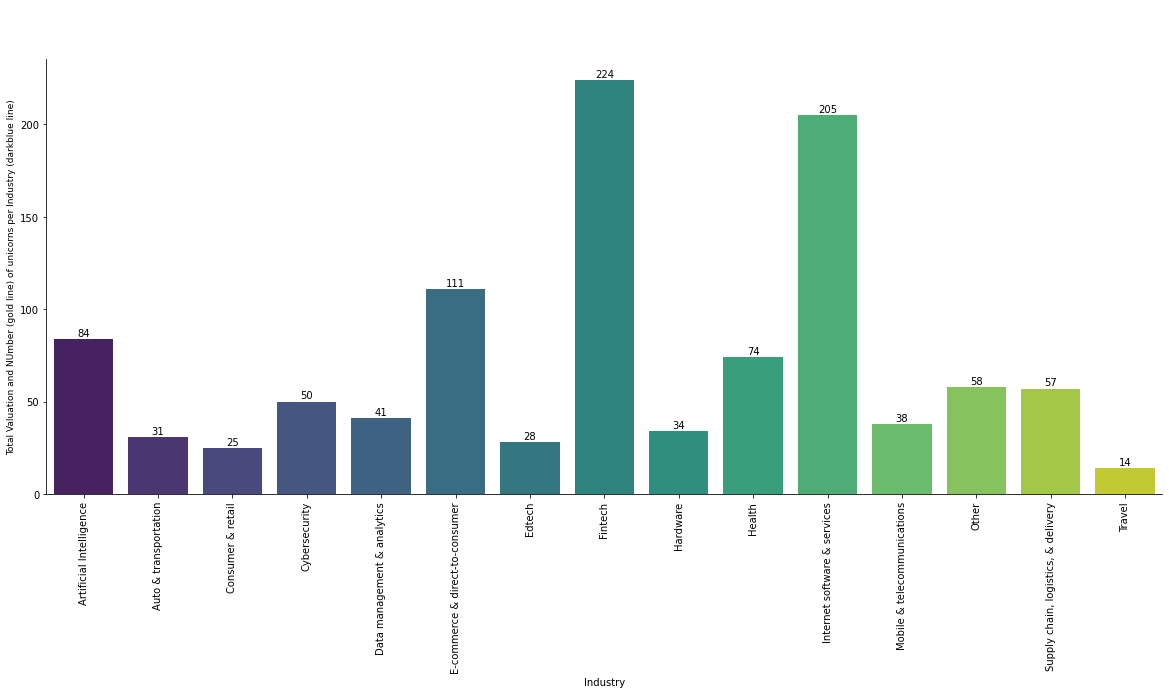

In [48]:
fig, ax= plt.subplots(figsize=(20,8))
# bar plot
sns.barplot(data=global_act, x="Industry", y="Company", orient="v", ax=ax, palette = 'viridis')

ax.bar_label(ax.containers[0], label_type="edge", padding=1); # add value lables
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title("\n\n", fontsize=15, fontweight="normal");
ax.set_ylabel("Total Valuation and NUmber (gold line) of unicorns per Industry (darkblue line)", fontsize=9, fontweight="normal");
ax.tick_params(axis="both", labelsize=10)
ax.xaxis.set_tick_params(labelrotation=90)

1.Fintech, Internet & Services,E-Commerce & direc-to-consumer,Artificial intelligence are top Industry of inverstors.
2.Fintech with more than 890 $B is in the firts.

# Conclusion:

##### We've seen that with some code from pandas and numpy libraries, we can extract and analyze data that helps us understand the current state of unicorns in the world. And of course, matplotlib and seaborn will help us visualize our results so we can understand them even better. But before we explore the data, the most important phase is cleaning the data, without which we might encounter some problems and our analysis might be affected.